In [1]:
import numpy as np
import pandas as pd
import pickle
import scipy as sp
import shap
import torch
import os

from datasets import Dataset, DatasetDict
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, PrecisionRecallDisplay, precision_score, recall_score
from sklearn.model_selection import train_test_split, KFold
from tqdm.notebook import trange
from ray import tune
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline, TrainingArguments, Trainer

os.environ["TOKENIZERS_PARALLELISM"] = "false"

2025-01-01 15:19:18.297785: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-01 15:19:18.297838: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-01 15:19:18.297866: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-01 15:19:18.303814: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-01 15:19:19.124033: W tensorflow/compiler/

In [2]:
### YOUR PATH HERE

#For execution in a devcontainer on a Linux server with Docker
filepath = '/workspaces/impactpharmacie'

#For execution in a devcontainer on a Windows PC running WSL with Docker
#filepath = '.'

# Import the dataset

In [3]:
df = pd.read_csv(filepath + '/data/static_oct2024_update/ratings.csv')[1:].fillna('')
df['labels'] = df.apply(lambda x: x['rating_consensus'] if x['rating_consensus'] != '' else x['rating1'] if ((x['rating1'] == x['rating2']) and (x['consensus_reason'] == '') and (x['rating1'] != '')) else 'error', axis=1)
test_df = df[-2400:]
train_val_df = df[:-2400]
print('Number of samples in all df: {}, Number of samples in test df: {}, Number of samples in train_val df: {}'.format(len(df),len(test_df), len(train_val_df)))

Number of samples in all df: 12024, Number of samples in test df: 2400, Number of samples in train_val df: 9624


In [4]:
train_df, val_df = train_test_split (train_val_df, test_size=0.2)

print('Length of train set: {}'.format(len(train_df)))
print('Length of val set: {}'.format(len(val_df)))
print('Number of included in train set: {} for ratio: {:.3f}'.format(train_df['labels'].sum(), train_df['labels'].sum()/len(train_df)))
print('Number of included in val set: {} for ratio: {:.3f}'.format(val_df['labels'].sum(), val_df['labels'].sum()/len(val_df)))

Length of train set: 7699
Length of val set: 1925
Number of included in train set: 488.0 for ratio: 0.063
Number of included in val set: 101.0 for ratio: 0.052


In [5]:
df_columns_to_keep = ['text', 'labels']
train_val_df = train_val_df[df_columns_to_keep]
train_df = train_df[df_columns_to_keep]
val_df = val_df[df_columns_to_keep]
test_df = test_df[df_columns_to_keep]

In [6]:
train_val_ds = Dataset.from_pandas(train_val_df)
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

ds = DatasetDict()
ds['train_val'] = train_val_ds
ds['train'] = train_ds
ds['val'] = val_ds
ds['test'] = test_ds

In [7]:
ds.cleanup_cache_files()
test_ds.cleanup_cache_files()

0

In [8]:
ds = ds.class_encode_column('labels')

Stringifying the column:   0%|          | 0/9624 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/9624 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/7699 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/7699 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/1925 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/1925 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/2400 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/2400 [00:00<?, ? examples/s]

## Helpful functions for the models

In [9]:
def compute_single_label_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    metrics = {'accuracy':accuracy_score(labels, predictions), 'f1':f1_score(labels, predictions), 'precision':precision_score(labels, predictions), 'recall':recall_score(labels, predictions)}
    return metrics

def tokenizer_function(samples):
    return tokenizer(samples['text'], padding="max_length", truncation=True, max_length=512)

# Evaluate different models

List of models to evaluate based on exploration of models available in Huggingface and cited in https://doi.org/10.1016/j.compbiomed.2024.108189 ( A comprehensive evaluation of large Language models on benchmark biomedical text processing tasks )

Planned strategy, list of models to be evaluated:
1. BiomedBERT base-abstract-fulltext // microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext
2. BiomedBERT base-abstract // microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract
3. BiomedBERT large-abstract // microsoft/BiomedNLP-BiomedBERT-large-uncased-abstract
4. BioBERT base-1.2 // dmis-lab/biobert-base-cased-v1.2
5. BioBERT large-1.1 // dmis-lab/biobert-large-cased-v1.1
6. BioBART v2-base // GanjinZero/biobart-v2-base
7. BioBART v2-large // GanjinZero/biobart-v2-large
8. BioELECTRA base-discriminator-pubmed // kamalkraj/bioelectra-base-discriminator-pubmed
9. BioELECTRA base-discriminator-pubmed-pmc // kamalkraj/bioelectra-base-discriminator-pubmed-pmc
10. BioELECTRA base-discriminator-pubmed-pmc-lt // kamalkraj/bioelectra-base-discriminator-pubmed-pmc-lt
11. BioGPT // microsoft/biogpt
12. BioGPT-large // microsoft/BioGPT-Large
13. BioGPT-Large-PubMedQA // microsoft/BioGPT-Large-PubMedQA

(BioBART models failed because or a tensor dimension error - seems to be incompatible with sequence classification models)
(BioELECTRA models can't even initialize - seem to need local training)
(BioGPT models are too large for the GPU of our current server - model training starts but then fails because of OOM error on the GPU - not evaluated)

Cell outputs removed from the notebook because too large.

In [22]:
%tensorboard

UsageError: Line magic function `%tensorboard` not found.


## Run1- Do a general hyperparameter search on the models to find candidates with reasonable performance

### BiomedBERT base-abstract-fulltext

In [ ]:
model = 'microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext'
model_short_name = 'BiomedBERT-base-abstract-fulltext'
run_number = '1'
saving_dir_name = 'run' + run_number + '/' + model_short_name + '-run' + run_number

tokenizer = AutoTokenizer.from_pretrained(model)

tokenized_datasets = ds.map(tokenizer_function, batched=True)

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model, num_labels=2)

hp_space = {
    'learning_rate':tune.choice([5e-5, 2e-5, 1e-5, 8e-6, 5e-6, 2e-6, 1e-6]),
    'num_train_epochs':tune.choice([1,2,3,4,5,6]),
    'per_device_train_batch_size':8
}

training_args = TrainingArguments(filepath + '/results/train_results/' + saving_dir_name, eval_strategy='epoch', save_strategy='no', disable_tqdm=True)
trainer = Trainer(model_init=model_init, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_datasets['train'], eval_dataset=tokenized_datasets['val'])
best_model = trainer.hyperparameter_search(hp_space=lambda _: hp_space, direction='maximize', n_trials=40, storage_path=filepath + '/results/tune_results/', name=saving_dir_name)

### BiomedBERT base-abstract

In [ ]:
model = 'microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract'
model_short_name = 'BiomedBERT-base-abstract'
run_number = '1'
saving_dir_name = 'run' + run_number + '/' + model_short_name + '-run' + run_number

tokenizer = AutoTokenizer.from_pretrained(model)

tokenized_datasets = ds.map(tokenizer_function, batched=True)

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model, num_labels=2)

hp_space = {
    'learning_rate':tune.choice([5e-5, 2e-5, 1e-5, 8e-6, 5e-6, 2e-6, 1e-6]),
    'num_train_epochs':tune.choice([1,2,3,4,5,6]),
    'per_device_train_batch_size':8
}

training_args = TrainingArguments(filepath + '/results/train_results/' + saving_dir_name, eval_strategy='epoch', save_strategy='no', disable_tqdm=True)
trainer = Trainer(model_init=model_init, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_datasets['train'], eval_dataset=tokenized_datasets['val'])
best_model = trainer.hyperparameter_search(hp_space=lambda _: hp_space, direction='maximize', n_trials=40, storage_path=filepath + '/results/tune_results/', name=saving_dir_name)

### BiomedBERT large-abstract

In [ ]:
model = 'microsoft/BiomedNLP-BiomedBERT-large-uncased-abstract'
model_short_name = 'BiomedBERT-large-abstract'
run_number = '1'
saving_dir_name = 'run' + run_number + '/' + model_short_name + '-run' + run_number

tokenizer = AutoTokenizer.from_pretrained(model)

tokenized_datasets = ds.map(tokenizer_function, batched=True)

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model, num_labels=2)

hp_space = {
    'learning_rate':tune.choice([5e-5, 2e-5, 1e-5, 8e-6, 5e-6, 2e-6, 1e-6]),
    'num_train_epochs':tune.choice([1,2,3,4,5,6]),
    'per_device_train_batch_size':8
}

training_args = TrainingArguments(filepath + '/results/train_results/' + saving_dir_name, eval_strategy='epoch', save_strategy='no', disable_tqdm=True)
trainer = Trainer(model_init=model_init, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_datasets['train'], eval_dataset=tokenized_datasets['val'])
best_model = trainer.hyperparameter_search(hp_space=lambda _: hp_space, direction='maximize', n_trials=40, storage_path=filepath + '/results/tune_results/', name=saving_dir_name)

### BioBERT base-1.2

In [ ]:
model = 'dmis-lab/biobert-base-cased-v1.2'
model_short_name = 'BioBERT-base'
run_number = '1'
saving_dir_name = 'run' + run_number + '/' + model_short_name + '-run' + run_number

tokenizer = AutoTokenizer.from_pretrained(model)

tokenized_datasets = ds.map(tokenizer_function, batched=True)

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model, num_labels=2)

hp_space = {
    'learning_rate':tune.choice([5e-5, 2e-5, 1e-5, 8e-6, 5e-6, 2e-6, 1e-6]),
    'num_train_epochs':tune.choice([1,2,3,4,5,6]),
    'per_device_train_batch_size':8
}

training_args = TrainingArguments(filepath + '/results/train_results/' + saving_dir_name, eval_strategy='epoch', save_strategy='no', disable_tqdm=True)
trainer = Trainer(model_init=model_init, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_datasets['train'], eval_dataset=tokenized_datasets['val'])
best_model = trainer.hyperparameter_search(hp_space=lambda _: hp_space, direction='maximize', n_trials=40, storage_path=filepath + '/results/tune_results/', name=saving_dir_name)

### BioBERT large-1.1

In [ ]:
model = 'dmis-lab/biobert-large-cased-v1.1'
model_short_name = 'BioBERT-large'
run_number = '1'
saving_dir_name = 'run' + run_number + '/' + model_short_name + '-run' + run_number

tokenizer = AutoTokenizer.from_pretrained(model)

tokenized_datasets = ds.map(tokenizer_function, batched=True)

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model, num_labels=2)

hp_space = {
    'learning_rate':tune.choice([5e-5, 2e-5, 1e-5, 8e-6, 5e-6, 2e-6, 1e-6]),
    'num_train_epochs':tune.choice([1,2,3,4,5,6]),
    'per_device_train_batch_size':8
}

training_args = TrainingArguments(filepath + '/results/train_results/' + saving_dir_name, eval_strategy='epoch', save_strategy='no', disable_tqdm=True)
trainer = Trainer(model_init=model_init, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_datasets['train'], eval_dataset=tokenized_datasets['val'])
best_model = trainer.hyperparameter_search(hp_space=lambda _: hp_space, direction='maximize', n_trials=40, storage_path=filepath + '/results/tune_results/', name=saving_dir_name)

### BioBART v2-base

In [ ]:
model = 'GanjinZero/biobart-v2-base'
model_short_name = 'BioBART-base'
run_number = '1'
saving_dir_name = 'run' + run_number + '/' + model_short_name + '-run' + run_number

tokenizer = AutoTokenizer.from_pretrained(model)

tokenized_datasets = ds.map(tokenizer_function, batched=True)

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model, num_labels=2)

hp_space = {
    'learning_rate':tune.choice([5e-5, 2e-5, 1e-5, 8e-6, 5e-6, 2e-6, 1e-6]),
    'num_train_epochs':tune.choice([1,2,3,4,5,6]),
    'per_device_train_batch_size':8
}

training_args = TrainingArguments(filepath + '/results/train_results/' + saving_dir_name, eval_strategy='epoch', save_strategy='no', disable_tqdm=True)
trainer = Trainer(model_init=model_init, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_datasets['train'], eval_dataset=tokenized_datasets['val'])
best_model = trainer.hyperparameter_search(hp_space=lambda _: hp_space, direction='maximize', n_trials=40, storage_path=filepath + '/results/tune_results/', name=saving_dir_name)

Test debug biobart

In [11]:
model = AutoModelForSequenceClassification.from_pretrained('GanjinZero/biobart-v2-base', num_labels=2)
training_args = TrainingArguments(filepath + '/models/test_debug/biobart-base', evaluation_strategy='no', logging_strategy='no', learning_rate=1e-5, num_train_epochs=4)
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_datasets['train_val'])
trainer.train()
trainer.save_model(filepath + '/models/test_debug/biobart-base/model')

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at GanjinZero/biobart-v2-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


/usr/local/lib/python3.11/site-packages/transformers/configuration_utils.py:384: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3}
  warnings.warn(
/usr/local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.11/site-packages/transformers/configuration_utils.py:384: UserWarning: Some non-default generation parameters are set in the model confi

In [12]:
trainer.evaluate(eval_dataset=tokenized_datasets['test'])

/usr/local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2400) + inhomogeneous part.

### BioBART v2-large

### BioELECTRA base-discriminator-pubmed

#### First test that it will work 
(avoid issue similar to BioBART)

In [13]:
model = AutoModelForSequenceClassification.from_pretrained('kamalkraj/bioelectra-base-discriminator-pubmed', num_labels=2)
training_args = TrainingArguments(filepath + '/models/test_debug/bioelectra-base', evaluation_strategy='no', logging_strategy='no', learning_rate=1e-5, num_train_epochs=4)
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_datasets['train_val'])
trainer.train()
trainer.save_model(filepath + '/models/test_debug/bioelectra-base/model')

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

OSError: kamalkraj/bioelectra-base-discriminator-pubmed does not appear to have a file named pytorch_model.bin, model.safetensors, tf_model.h5, model.ckpt or flax_model.msgpack.

### BioELECTRA base-discriminator-pubmed-pmc

### BioELECTRA base-discriminator-pubmed-pmc-lt

### BioGPT

Setting batch_size to 4 to see if it works, with 8 all trials end in out of memory error.

In [ ]:
model = 'microsoft/biogpt'
model_short_name = 'BioGPT'
run_number = '1'
saving_dir_name = 'run' + run_number + '/' + model_short_name + '-run' + run_number

tokenizer = AutoTokenizer.from_pretrained(model)

tokenized_datasets = ds.map(tokenizer_function, batched=True)

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model, num_labels=2)

hp_space = {
    'learning_rate':tune.choice([5e-5, 2e-5, 1e-5, 8e-6, 5e-6, 2e-6, 1e-6]),
    'num_train_epochs':tune.choice([1,2,3,4,5,6]),
    'per_device_train_batch_size':4
}

training_args = TrainingArguments(filepath + '/results/train_results/' + saving_dir_name, eval_strategy='epoch', save_strategy='no', disable_tqdm=True)
trainer = Trainer(model_init=model_init, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_datasets['train'], eval_dataset=tokenized_datasets['val'])
best_model = trainer.hyperparameter_search(hp_space=lambda _: hp_space, direction='maximize', n_trials=40, storage_path=filepath + '/results/tune_results/', name=saving_dir_name)

### BioGPT-large

### BioGPT-large-PubMedQA

## Run2- Further explore the hyperparameter space of the models who rated best

- BiomedBERT-base-abstract 8e-6x4
- BiomedBERT-base-abstract 1e-5x2
- BiomedBERT-base-abstract 2e-5x4
- BiomedBERT-base-abstract 2e-5x4


- BiomedBERT-large-abstract 8e-6x2
- BiomedBERT-large-abstract 8e-6x4
- BiomedBERT-large-abstract 2e-5x4


Results: BiomedBERT-base abstract 2e-5x3 seems to give the most consistent results with recall of 0.86 and precision of 0.78-0.79-0.8

### BiomedBERT-base-abstract

BiomedBERT base-abstract // microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract


In [ ]:
model = 'microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract'
model_short_name = 'BiomedBERT-base-abstract'
run_number = '2'
saving_dir_name = 'run' + run_number + '/' + model_short_name + '-run' + run_number

tokenizer = AutoTokenizer.from_pretrained(model)

tokenized_datasets = ds.map(tokenizer_function, batched=True)

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model, num_labels=2)

hp_space = {
    'learning_rate':tune.grid_search([5e-5, 2e-5, 1e-5, 8e-6, 5e-6]),
    'num_train_epochs':tune.grid_search([1,2,3,4,5,6]),
    'per_device_train_batch_size':8
}

training_args = TrainingArguments(filepath + '/results/train_results/' + saving_dir_name, eval_strategy='epoch', save_strategy='no', disable_tqdm=True)
trainer = Trainer(model_init=model_init, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_datasets['train'], eval_dataset=tokenized_datasets['val'])
best_model = trainer.hyperparameter_search(hp_space=lambda _: hp_space, direction='maximize', n_trials=3, storage_path=filepath + '/results/tune_results/', name=saving_dir_name)

### BiomedBERT-large-abstract

BiomedBERT large-abstract // microsoft/BiomedNLP-BiomedBERT-large-uncased-abstract

In [ ]:
model = 'microsoft/BiomedNLP-BiomedBERT-large-uncased-abstract'
model_short_name = 'BiomedBERT-large-abstract'
run_number = '2'
saving_dir_name = 'run' + run_number + '/' + model_short_name + '-run' + run_number

tokenizer = AutoTokenizer.from_pretrained(model)

tokenized_datasets = ds.map(tokenizer_function, batched=True)

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model, num_labels=2)

hp_space = {
    'learning_rate':tune.grid_search([5e-5, 2e-5, 1e-5, 8e-6, 5e-6]),
    'num_train_epochs':tune.grid_search([1,2,3,4,5,6]),
    'per_device_train_batch_size':8
}

training_args = TrainingArguments(filepath + '/results/train_results/' + saving_dir_name, eval_strategy='epoch', save_strategy='no', disable_tqdm=True)
trainer = Trainer(model_init=model_init, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_datasets['train'], eval_dataset=tokenized_datasets['val'])
best_model = trainer.hyperparameter_search(hp_space=lambda _: hp_space, direction='maximize', n_trials=3, storage_path=filepath + '/results/tune_results/', name=saving_dir_name)

tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

Map:   0%|          | 0/9624 [00:00<?, ? examples/s]

Map:   0%|          | 0/7699 [00:00<?, ? examples/s]

Map:   0%|          | 0/1925 [00:00<?, ? examples/s]

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

# Evaluate the selected model on the test set without threshold adjustment

In [ ]:
model_name = 'microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenized_datasets = ds.map(tokenizer_function, batched=True)
training_args = TrainingArguments(filepath + '/models/test_set_eval_models/inclusion_biomedbert', eval_strategy='no', logging_strategy='no', learning_rate=2e-5, num_train_epochs=3)
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_datasets['train_val'])
trainer.train()
trainer.save_model(filepath + '/models/test_set_eval_models/inclusion_biomedbert/model')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/9624 [00:00<?, ? examples/s]

Map:   0%|          | 0/7699 [00:00<?, ? examples/s]

Map:   0%|          | 0/1925 [00:00<?, ? examples/s]

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


/usr/local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [13]:
trainer.evaluate(eval_dataset=tokenized_datasets['test'])

/usr/local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.08033862709999084,
 'eval_accuracy': 0.9758333333333333,
 'eval_f1': 0.7363636363636363,
 'eval_precision': 0.680672268907563,
 'eval_recall': 0.801980198019802,
 'eval_runtime': 39.8548,
 'eval_samples_per_second': 60.219,
 'eval_steps_per_second': 1.882,
 'epoch': 3.0}

# Determine thresholds to automatically exclude papers
Goal: Recall = 1

In [14]:
model_name = 'microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract'

all_df = df[df_columns_to_keep]
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512}

def tokenizer_function(samples):
    return tokenizer(samples['text'], padding="max_length", truncation=True, max_length=512)

                                                text  labels
2  Leveraging the pharmacy executive beyond the p...     0.0
3  The utilization of simulated patients for teac...     0.0
5  Exploration of pharmacist comfort with harm re...     0.0
6  Challenges for Polish Community Pharmacists in...     0.0
7  Pharmacists' Perceptions of Handling Antimicro...     0.0
                                                 text  labels
1   The utility of Conversation Analysis versus Ro...     0.0
4   Implementing an Antimicrobial Stewardship Prog...     0.0
9   Development and Implementation of In-House Pha...     0.0
11  A multifaceted approach in leveraging electron...     0.0
15  Identifying COVID-19 and H1N1 vaccination hesi...     0.0


Stringifying the column:   0%|          | 0/9619 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/9619 [00:00<?, ? examples/s]

Map:   0%|          | 0/9619 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


/usr/local/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


  0%|          | 0/2405 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


                                                text  labels
1  The utility of Conversation Analysis versus Ro...     0.0
2  Leveraging the pharmacy executive beyond the p...     0.0
3  The utilization of simulated patients for teac...     0.0
4  Implementing an Antimicrobial Stewardship Prog...     0.0
5  Exploration of pharmacist comfort with harm re...     0.0
                                                 text  labels
13  Implementing a personalized pharmaceutical pla...     0.0
21  Development and Implementation of Interprofess...     0.0
24  Prescribing of Pressor Agents in Septic Shock:...     0.0
31  Strategy to Improve Efficiency of Comprehensiv...     0.0
33  Impact of a Clinical Decision-Support Tool on ...     0.0


Stringifying the column:   0%|          | 0/9619 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/9619 [00:00<?, ? examples/s]

Map:   0%|          | 0/9619 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


/usr/local/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


  0%|          | 0/2405 [00:00<?, ?it/s]

                                                text  labels
1  The utility of Conversation Analysis versus Ro...     0.0
2  Leveraging the pharmacy executive beyond the p...     0.0
3  The utilization of simulated patients for teac...     0.0
4  Implementing an Antimicrobial Stewardship Prog...     0.0
5  Exploration of pharmacist comfort with harm re...     0.0
                                                 text  labels
16  Economic impact and health care utilization ou...     0.0
27  An Evaluation of Pharmacist-Led Interventions ...     1.0
28  The Unmet Need for Pharmacists as Important Me...     0.0
29  Team Communication on Tasks Performed in Blood...     0.0
35  Preventing Prescription Drug Abuse: A Pharmacy...     0.0


Stringifying the column:   0%|          | 0/9619 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/9619 [00:00<?, ? examples/s]

Map:   0%|          | 0/9619 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


/usr/local/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


  0%|          | 0/2405 [00:00<?, ?it/s]

                                                text  labels
1  The utility of Conversation Analysis versus Ro...     0.0
2  Leveraging the pharmacy executive beyond the p...     0.0
4  Implementing an Antimicrobial Stewardship Prog...     0.0
5  Exploration of pharmacist comfort with harm re...     0.0
6  Challenges for Polish Community Pharmacists in...     0.0
                                                 text  labels
3   The utilization of simulated patients for teac...     0.0
7   Pharmacists' Perceptions of Handling Antimicro...     0.0
8   Metabolic Activation of the Toxic Natural Prod...     0.0
19  The psychological health of patients diagnosed...     0.0
23  Comparison of Interventions Made in an Ambulat...     1.0


Stringifying the column:   0%|          | 0/9619 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/9619 [00:00<?, ? examples/s]

Map:   0%|          | 0/9619 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


/usr/local/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


  0%|          | 0/2405 [00:00<?, ?it/s]

                                                text  labels
1  The utility of Conversation Analysis versus Ro...     0.0
3  The utilization of simulated patients for teac...     0.0
4  Implementing an Antimicrobial Stewardship Prog...     0.0
7  Pharmacists' Perceptions of Handling Antimicro...     0.0
8  Metabolic Activation of the Toxic Natural Prod...     0.0
                                                 text  labels
2   Leveraging the pharmacy executive beyond the p...     0.0
5   Exploration of pharmacist comfort with harm re...     0.0
6   Challenges for Polish Community Pharmacists in...     0.0
10  Pharmacists' perceived role in supporting diab...     0.0
12  Decision coaching for people making healthcare...     0.0


Stringifying the column:   0%|          | 0/9620 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/9620 [00:00<?, ? examples/s]

Map:   0%|          | 0/9620 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


/usr/local/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


  0%|          | 0/2404 [00:00<?, ?it/s]

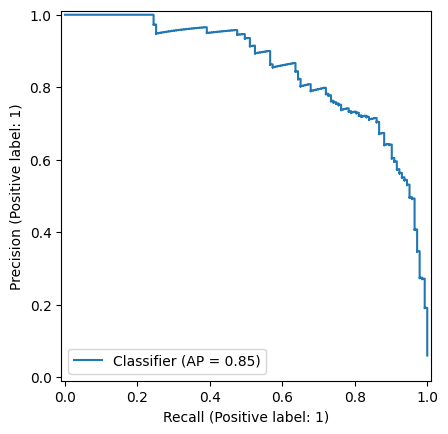

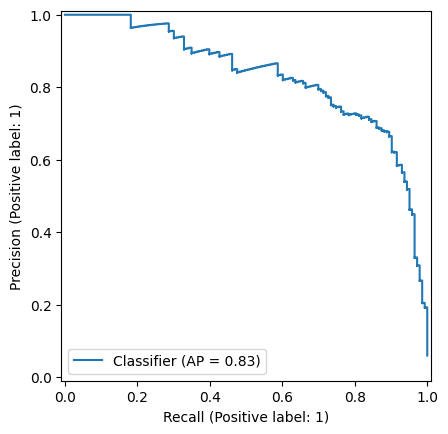

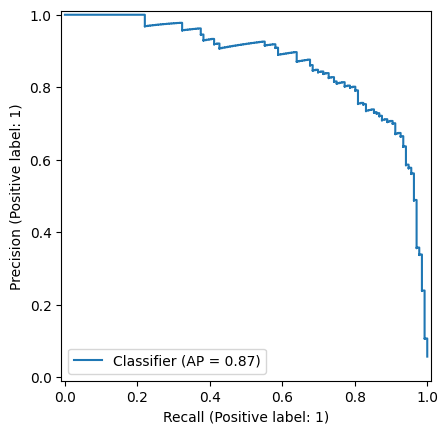

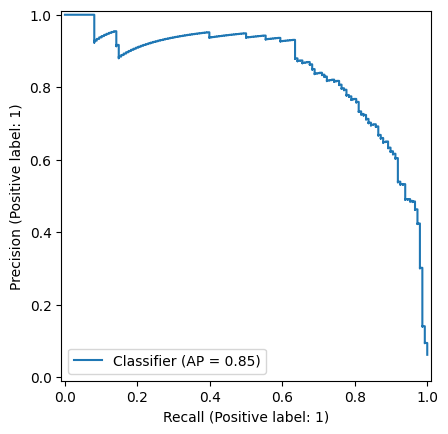

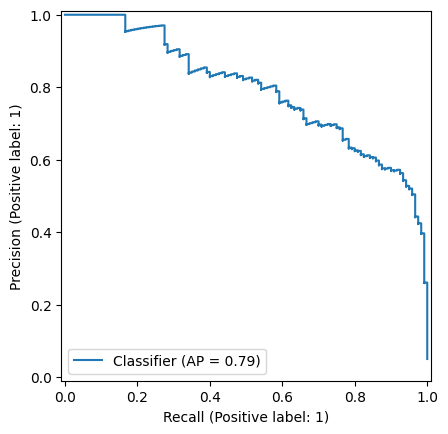

In [15]:
kf = KFold(n_splits=5, shuffle=True)
thresholds = []

for train_idx, val_idx in kf.split(all_df):
    train = all_df.iloc[train_idx]
    print(train.head())
    val = all_df.iloc[val_idx]
    print(val.head())
    ds = Dataset.from_pandas(train)
    ds.cleanup_cache_files()
    ds = ds.class_encode_column('labels')

    tokenized_ds = ds.map(tokenizer_function, batched=True)

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    training_args = TrainingArguments(filepath + '/.temp', save_strategy='no', eval_strategy='no', logging_strategy='no', overwrite_output_dir=True, learning_rate=2e-5, num_train_epochs=3)
    trainer = Trainer(model=model, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_ds)
    trainer.train()

    pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None, device=0)
    scores = []
    for i in trange(len(val)):
        scores.append(pipe(val.iloc[i]['text'], **tokenizer_kwargs)[0][1]['score'])

    PrecisionRecallDisplay.from_predictions(val['labels'], scores)

    pr,re,th = precision_recall_curve(val['labels'], scores)
    rth_df = pd.DataFrame.from_dict({'precision':pr[:-1],'recall':re[:-1],'threshold':th})

    ceiling_recall = 0.99
    thresholds.append(rth_df[rth_df.recall >= ceiling_recall].iloc[-1]['threshold'])

In [16]:
thr_df = pd.DataFrame(thresholds)
thr_df

,0
0,0.000509
1,0.000510
2,0.000687
3,0.000518
4,0.001695


In [17]:
threshold = thr_df.mean()[0]
print('Mean threshold: {:.20f}'.format(threshold))
recall_test = []
preds = []
incorrect = []
for i, label, score in zip(range(len(val['labels'])), val['labels'], scores):
    if score >= threshold:
        recall_test.append({'index':i, 'label':label, 'score':score})
        preds.append(1)
    else:
        if label == 1:
            incorrect.append(i)
        preds.append(0)
print('Number of abstracts excluded from review based on recall threshold: {} out of {} for ratio of {:.3f}'.format(len(val) - len(recall_test), len(val), (len(val) - len(recall_test)) / len(val)))
print('Adjusted threshold precision: {:.3f}, recall: {:.3f}, f1: {:.3f}, accuracy: {:.3f}'.format(precision_score(val['labels'], preds), recall_score(val['labels'], preds), f1_score(val['labels'], preds), accuracy_score(val['labels'], preds)))
print('Number of incorrectly excluded abstracts: {}'.format(len(incorrect)))


Mean threshold: 0.00078370631672441959
Number of abstracts excluded from review based on recall threshold: 1908 out of 2404 for ratio of 0.794
Adjusted threshold precision: 0.242, recall: 1.000, f1: 0.390, accuracy: 0.844
Number of incorrectly excluded abstracts: 0
